<a href="https://colab.research.google.com/github/ayresjs/che525Instrumentation/blob/main/Final%20Report%20Forecasting%20Code%2C%20Ayres%2C%20Griffin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import io
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt

In [ ]:
!pip install -q prophet
from prophet import Prophet

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/Bradley1735656/che525Instrumentation/refs/heads/main/1-4%20Pass%20HX%20Project%20Data.csv")

In [ ]:
def check_configuration(row):

  if abs(row['TE-800-15'] - row['TE-800-16']) / max(row['TE-800-15'], row['TE-800-16']) > 0.05:
    return '1-4 Pass'

  elif abs(row['TE-800-16'] - row['TE-800-14']) / max(row['TE-800-16'], row['TE-800-14']) <= 0.05:
    return '1-1 Pass'

  elif abs(row['TE-800-09'] - row['TE-800-12']) / max(row['TE-800-09'], row['TE-800-12']) <= 0.05:
    return '1-2 Pass'
  else:
    return 'Other configuration'

df['Configuration'] = df.apply(check_configuration, axis=1)

print(df['Configuration'].value_counts())



Configuration
1-4 Pass    301
Name: count, dtype: int64


In [ ]:
df.sample(2)

,Unnamed: 0,Timestamp,FIT-800-00,FIT-800-01,FIT-800-02,FIT-800-03,FIT-800-04,TE-800-01,TE-800-02,TE-800-03,...,TE-800-08,TE-800-09,TE-800-10,TE-800-11,TE-800-12,TE-800-13,TE-800-14,TE-800-15,TE-800-16,Configuration
107,107,2025-01-29 15:03:47-05:00,1.789836,13.496033,19.993515,0.000095,7.612440,25.073242,28.870392,28.421783,...,120.418549,20.843506,20.97168,23.583221,23.374939,22.573853,23.807526,19.113159,22.4617,1-4 Pass
130,130,2025-01-29 15:04:10-05:00,1.786260,13.512245,19.993515,0.000095,7.599803,25.073242,28.918457,28.421783,...,120.274353,20.843506,20.97168,23.535156,23.326874,22.573853,23.775482,19.113159,22.4617,1-4 Pass


In [ ]:
df = df.rename(columns={'Timestamp': 'ds', 'TE-800-04': 'y'})

In [ ]:
df['ds'] = pd.to_datetime(df['ds'])
df['ds'] = df['ds'].dt.tz_localize(None)
print(df['ds'].dtype)
df.sample(2)

datetime64[ns]


,Unnamed: 0,ds,FIT-800-00,FIT-800-01,FIT-800-02,FIT-800-03,FIT-800-04,TE-800-01,TE-800-02,TE-800-03,...,TE-800-08,TE-800-09,TE-800-10,TE-800-11,TE-800-12,TE-800-13,TE-800-14,TE-800-15,TE-800-16,Configuration
0,0,2025-01-29 15:02:00,1.777915,13.500801,19.986839,0.000095,7.626507,25.073242,28.822327,28.373718,...,120.450592,20.891571,21.019745,23.583221,23.326874,22.573853,23.775482,19.113159,22.461700,1-4 Pass
141,141,2025-01-29 15:04:21,1.798181,13.491264,20.013542,0.000095,7.644866,25.073242,28.822327,28.421783,...,120.322418,20.843506,21.067810,23.615265,23.374939,22.573853,23.775482,19.113159,22.509766,1-4 Pass


In [ ]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4o6cu5_x/95wpipoz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4o6cu5_x/g9qxexhe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7804', 'data', 'file=/tmp/tmp4o6cu5_x/95wpipoz.json', 'init=/tmp/tmp4o6cu5_x/g9qxexhe.json', 'output', 'file=/tmp/tmp4o6cu5_x/prophet_model6a9ko886/prophet_model-20250522021950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:19:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:19:51 - cmdstanpy - INFO - Chain 

In [ ]:
future = m.make_future_dataframe(periods=30, freq='10s')
future.tail()

,ds
326,2025-01-29 15:11:20
327,2025-01-29 15:11:30
328,2025-01-29 15:11:40
329,2025-01-29 15:11:50
330,2025-01-29 15:12:00


In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
326,2025-01-29 15:11:20,24.751398,22.394117,27.254163
327,2025-01-29 15:11:30,24.755023,22.258868,27.427348
328,2025-01-29 15:11:40,24.758648,22.135158,27.587931
329,2025-01-29 15:11:50,24.762273,21.977161,27.736686
330,2025-01-29 15:12:00,24.765899,21.803977,27.852462


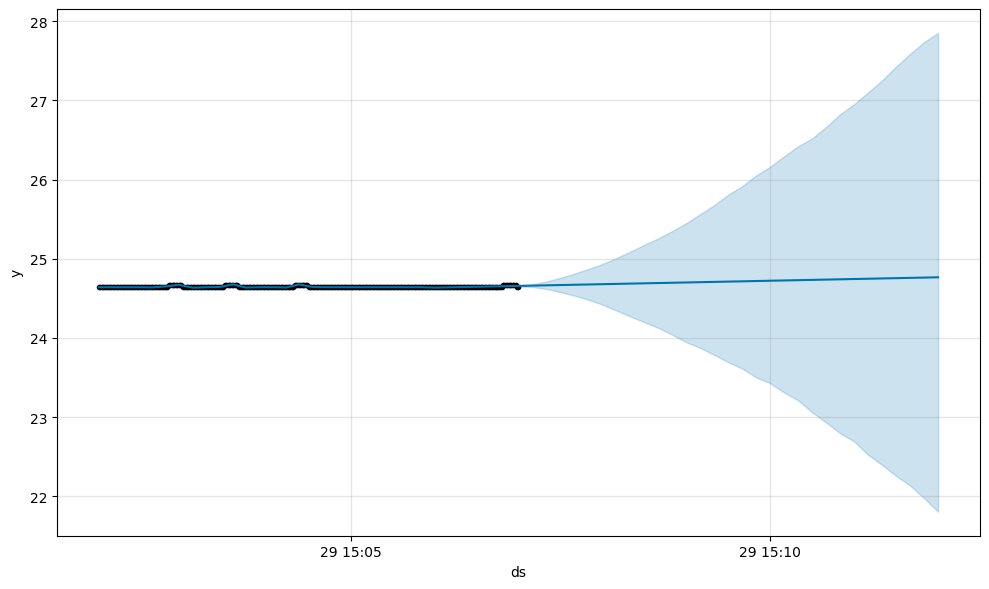

In [ ]:
fig1 = m.plot(forecast)